In [1]:
import os, sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(f"sys.path.append(parent_dir): {parent_dir}")
sys.path.append(parent_dir)

from utils.load_h5 import Dataset4h5, ranges_dict
from utils.plot_mp4 import plot_mp4
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase

import numpy as np
from torch.utils.data import DataLoader
import h5py
import matplotlib as mpl
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
from scipy.linalg import sqrtm

import torch
from matplotlib.lines import Line2D
from kymatio.torch import Scattering2D

from scipy.interpolate import interp1d
import joblib
from tqdm import tqdm
import gc

import multiprocessing
import matplotlib.ticker as ticker
from cycler import cycler

from numpy import interp
from matplotlib.ticker import FuncFormatter
import matplotlib
from typing import List
import argparse

import os

multiprocessing.set_start_method('spawn', force=True)

gridspec_kw = {'height_ratios': [3,.5,.5,.5]}

sys.path.append(parent_dir): /pscratch/sd/b/binxia/ml21cm


In [2]:
def labelize(param):
    param = param.tolist()
    param[0] = round(param[0], 1)
    param[1] = int(round(param[1], 0))
    label = r"$(\log_{10}T_{\rm vir},\zeta)=$" + f"{tuple(param)}"
    return label

In [3]:
def load_h5_as_tensor(dir_name='LEN128-DIM64-CUB8.h5', num_image=256, num_redshift=1024, HII_DIM=64, z_step=1, scale_path=False, dim=3, startat=0, pt_fname=None, transform=False):
    dir_name = os.path.join(os.environ['SCRATCH'], dir_name)
    dataset = Dataset4h5(dir_name, num_image=num_image, num_redshift=num_redshift, HII_DIM=HII_DIM, z_step=z_step, scale_path=scale_path, dim=dim, startat=startat)

    with h5py.File(dir_name) as f:
        los = f['redshifts_distances'][:,startat:startat+dataset.num_redshift:z_step]
    # print(f"🆘 {los.shape=}; {startat=}; {dataset.num_redshift=}")

    dataloader = DataLoader(dataset, batch_size=800)
    
    x, c = next(iter(dataloader))

    if 'pt' == transform and (pt_fname is not None):
        original_shape = x.shape
        pt = joblib.load(pt_fname)
        x = pt.transform(x.reshape(-1, 1))
        x = torch.from_numpy(x.reshape(*original_shape))

    return x, c, los

os.environ["SLURM_NODEID"] = '0'

In [4]:
def get_eor_cmap(vmin=-150, vmax=30):
    name = f"EoR-{vmin}-{vmax}"

    EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list(
        name,
        [
            (0, 'white'),
            (0.33, 'yellow'),
            (0.5, 'orange'),
            (0.68, 'red'),
            (0.83333333, 'black'),
            (0.9, 'blue'),
            (1, 'cyan')])
    
    try:
        matplotlib.colormaps.register(cmap=EoR_colour)
    except ValueError:
        matplotlib.colormaps.unregister(name)
        matplotlib.colormaps.register(cmap=EoR_colour)

    return name

vmin = -150
vmax = 30
cmap = get_eor_cmap(vmin, vmax)

def calc_ps(field, L):
    ng = field.shape[0]
    ru = np.fft.fftn(field)
    
    ru *= (L/ng)**field.ndim

    if field.ndim == 3:
        ru = ru[0:ng//2+1, 0:ng//2+1, 0:ng//2+1]
    elif field.ndim ==2:
        ru = ru[0:ng//2+1, 0:ng//2+1]

    # ru *= (2/ng)**field.ndim
    ru = np.abs(ru)**2

    kx = np.fft.rfftfreq(ng) * ng / L
    ky = kx.copy()
    kz = kx.copy()

    kmin = 1/L
    kmax = 0.5*ng/L
    
    kbins = np.arange(kmin, kmax, kmin)
    Nk = len(kbins)
    
    if field.ndim == 3:
        k_nd = np.meshgrid(kx, ky, kz, indexing="ij")
    elif field.ndim == 2:
        k_nd = np.meshgrid(kx, ky, indexing="ij")
    
    k = np.sqrt(np.sum(np.array(k_nd)**2,axis=0))

    Pk = np.array([np.mean(ru[(k >= kbins[i]) & (k < kbins[i+1])]) for i in range(len(kbins)-1)])
    kbins = (kbins[:-1] + kbins[1:])/2

    if field.ndim == 3:
        Pk *= (kbins**3) / (2*np.pi**2)
    elif field.ndim == 2:
        Pk *= (kbins**2) / (2*np.pi)

    return kbins, Pk

def x2Pk(x, z_idx=0):
    print(f"x2Pk, x.shape = {x.shape}")
    Pk_vals_all = []
    for i in range(x.shape[0]):
        if x.ndim == 4:
            # density_field = x[i,0]
            density_field = x[i,0,:,z_idx:z_idx+x.shape[-2]]
        elif x.ndim == 5:
            # density_field = x[i,0,...,z_idx]
            density_field = x[i,0,0,:,z_idx:z_idx+x.shape[-2]]
        if density_field.ndim == 3:
            Nx, Ny, Nz = density_field.shape
            box_size = 128#(128.0, 128.0, 1024.0) #512#
        elif density_field.ndim == 2:
            Nx, Ny = density_field.shape
            box_size = 128#(128.0, 1024.0) #512#

        # 计算物质功率谱
        k_vals, Pk_vals = calc_ps(density_field, box_size)
        # k_vals_all.append(k_vals)
        Pk_vals_all.append(Pk_vals)

    Pk_vals_all = np.array(Pk_vals_all)
    return k_vals, Pk_vals_all

    
def x2Tb(x):
    #print('x.shape =', x.shape, 'x.ndim =', x.ndim)
    if x.ndim == 4:
        Tb = x[:,0].mean(axis=1)
    elif x.ndim == 5:
        Tb = x[:,0].mean(axis=(1,2))
    return Tb

def load_x_ml(fname_pattern0, fname_pattern1, ema = 0, outputs_dir = "../training/outputs", pt_fname=None, transform=False):
    # num = 7200
    x_ml = []
    fnames = [fname for fname in os.listdir(outputs_dir) if fname_pattern0 in fname and fname_pattern1 in fname and f'-ema{ema}' in fname]
    if len(fnames) == 0:
        raise ValueError(f"No files found with patterns: {fname_pattern0}, {fname_pattern1} in {outputs_dir}")
    else:
        print("fname pattern:", fname_pattern0, fname_pattern1, "; len(fnames) =", len(fnames), ";\nfnames[0] =", fnames[0])

    for fname in fnames:
        data = np.load(os.path.join(outputs_dir, fname))
        x_ml.append(data)

    x_ml = np.concatenate(x_ml, axis=0)
    original_shape = x_ml.shape

    if 'pt_inv' == transform and (pt_fname is not None):
        pt = joblib.load(pt_fname)
        x_ml = pt.inverse_transform(x_ml.reshape(-1, 1))
    elif 'min_max' == transform:
        min_val, max_val = ranges_dict[transform]
        x_ml = x_ml * (max_val - min_val) + min_val
    elif 'z_score' == transform:
        mean_val, std_val = ranges_dict[transform]
        x_ml = x_ml * std_val + mean_val
    elif 'arcsinh' == transform:
        # inverse arcsinh
        x_ml = np.sinh(x_ml)

    x_ml = torch.from_numpy(x_ml.reshape(*original_shape))
    print(f"loaded x_ml.shape = {x_ml.shape}")
    return x_ml


# === 自定义 handler：让矩形和虚线重叠显示 ===
class HandlerRectLine(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        # 画矩形
        rect = Rectangle((x0, y0), width, height,
                         facecolor=orig_handle.get('rect_fc', 'black'),
                         edgecolor=orig_handle.get('rect_ec', 'black'),
                         alpha=orig_handle.get('rect_alpha', 0.3),
                         transform=trans)
        # 画中间的虚线
        line = Line2D([x0, x0 + width], [y0 + height/2, y0 + height/2],
                      color=orig_handle.get('line_color', 'black'),
                      linestyle=orig_handle.get('line_ls', ':'),
                      linewidth=orig_handle.get('line_lw', 1.5),
                      transform=trans)
        return [rect, line]

In [5]:
def plot_global_signal(x_pairs, params, los, sigma_level=68.27, alpha=0.2, lw = 0.6, y_eps = 0, savename=None, z_idx=None):
    low = (100 - sigma_level) / 2
    high = 100 - low
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,6), dpi=200, gridspec_kw=gridspec_kw)
    
    eps_rel_list = []
    eps_std_list = []
    eps_sigma_list = []
    for i, (x0, x1) in enumerate(x_pairs):
        interval = x0.shape[-1] // 100

        Tb0 = x2Tb(x0)
        Tb1 = x2Tb(x1)
        
        y0 = np.median(Tb0, axis=0)
        y1 = np.median(Tb1, axis=0)

        Tb0_perc = np.percentile(Tb0, [low, high], axis=0)
        ax[0].fill_between(los[1,:Tb0_perc.shape[-1]], Tb0_perc[0], Tb0_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')
        Tb1_perc = np.percentile(Tb1, [low, high], axis=0)
        yerr_lower = y1 - Tb1_perc[0]
        yerr_upper = Tb1_perc[1] - y1
        ax[0].errorbar(los[1,:Tb0_perc.shape[-1]][::interval], y1[::interval], yerr=[yerr_lower[::interval], yerr_upper[::interval]], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=lw)

        ax[0].plot(los[1,:Tb0_perc.shape[-1]], y0, linestyle=':', c=f"C{i}", lw=3*lw)

        eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
        eps_rel_list.append(eps_rel)
        ax[1].plot(los[1,:Tb0_perc.shape[-1]][abs(y0)>y_eps], eps_rel, label=labelize(params[i]), c=f"C{i}", lw=lw)

        sigma0 = 0.5*(Tb0_perc[1]-Tb0_perc[0])
        sigma1 = 0.5*(Tb1_perc[1]-Tb1_perc[0])
        eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
        eps_std_list.append(eps_std)
        ax[2].plot(los[1,:Tb0_perc.shape[-1]][sigma0>y_eps], eps_std, label=labelize(params[i]), c=f"C{i}", lw=lw)
        
        eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]
        eps_sigma_list.append(eps_sigma)
        ax[3].plot(los[1,:Tb0_perc.shape[-1]][sigma0>y_eps], eps_sigma, c=f"C{i}", lw=lw)

    ax[0].set_ylabel(r'$\langle T_b \rangle$ [mK]')
    ax[0].grid()

    if z_idx != None:
        for ax_i in ax:
            ax_i.axvline(x=los[1][z_idx], color='red', linestyle='--', linewidth=2)

    # === 你已有的 legend 准备部分 ===
    ax1_handles, ax1_labels = ax[1].get_legend_handles_labels()

    legend_line2 = Line2D([0], [0], linestyle='-', color='black', marker='|', markersize=8)

    # 这里用 dict 来定义“矩形+虚线”组合
    legend_handle_rectline = {
        'rect_fc': 'black',
        'rect_ec': 'black',
        'rect_alpha': alpha,    # 你原来的透明度参数
        'line_color': 'black',
        'line_ls': ':',
    }

    legend_elements = [
        legend_handle_rectline,   # 会被 HandlerRectLine 处理，绘制叠加图例
        legend_line2
    ]

    legend_labels = ['21cmfast', 'diffusion']

    # === 添加图例 ===
    ax[0].legend(
        legend_elements + ax1_handles,
        legend_labels + ax1_labels,
        handler_map={dict: HandlerRectLine()},  # 替代原来的 tuple handler
        # fontsize=8,
    )

    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    MAE_rel = np.abs(np.concatenate(eps_rel_list)).mean()
    # MAE_rel = np.abs(x := np.concatenate(eps_rel_list))[np.isfinite(x)].mean()
    ax[1].text(0, 0.5, r"$\overline{|\epsilon_{rel}|}$" + f" = {MAE_rel:.2f}", transform=ax[1].transAxes, ha='left', va='bottom', fontsize=13)
    ax[1].set_ylim(-1.99,1.99)
    ax[2].set_ylim(-1.99,1.99)
    ax[3].set_ylim(-1.99,1.99)
    ax[1].grid()

    ax[2].set_ylabel(r"$\epsilon_{std}$")
    MAE_std = np.abs(np.concatenate(eps_std_list)).mean()
    # MAE_std = np.abs(x := np.concatenate(eps_std_list))[np.isfinite(x)].mean()
    
    ax[2].text(0, 0.5, r"$\overline{|\epsilon_{std}|}$" + f" = {MAE_std:.2f}", transform=ax[2].transAxes, ha='left', va='bottom', fontsize=13)
    
    ax[3].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x / 1000:.1f}'))
    ax[3].set_xlabel('distance [Gpc]')

    ax[2].grid()
    ax[3].grid()
    
    ax[3].set_ylabel(r"$\epsilon_{\sigma}$")
    MAE_sigma = np.abs(np.concatenate(eps_sigma_list)).mean()
    # MAE_sigma = np.abs(x := np.concatenate(eps_sigma_list))[np.isfinite(x)].mean()

    ax[3].text(0, 0.5, r"$\overline{|\epsilon_{\sigma}|}$" + f" = {MAE_sigma:.2f}", transform=ax[3].transAxes, ha='left', va='bottom', fontsize=13)
    
    ax_twin = ax[0].secondary_xaxis('top')               # 创建共享 y 轴的第二个 x 轴
    ax_twin.set_xlim(ax[0].get_xlim())       # 设置副 x 轴的范围与主 x 轴相同
    ax_twin.set_xlabel('redshift')           # 设置副 x 轴标签
    ax_twin.xaxis.set_major_locator(ticker.MaxNLocator(10))  # 这里5表示最多显示5个刻度
    ax_twin.set_xticks(ax_twin.get_xticks())                  # 设置刻度为 z 的值
    z_ticks = interp(ax_twin.get_xticks(), los[1], los[0])
    ax_twin.set_xticklabels([f"{ztick:.1f}" for ztick in z_ticks])
    ax_twin.spines['bottom'].set_position(('outward', 10))  # 将副 x 轴向外移动 40 像素
    
    for axis in ax:
        axis.tick_params(axis='y', labelsize=10)  # 设置所有子图的 y 轴刻度标签字体大小为 8

    plt.subplots_adjust(hspace=0)
    if savename == None:
        plt.show()
    else:
        savename = f"global_Tb_{savename}_z{z_idx}.png"
        plt.savefig(savename, bbox_inches='tight',)
        print(f'Image saved to {savename}')
        # plt.show()
        plt.close()


# In[35]:

In [6]:
def plot_power_spectrum(x_pairs, params, los, sigma_level=68.27, alpha=0.2, z_idx=0, savename=None, y_eps=0):
    low = (100 - sigma_level) / 2
    high = 100 - low
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(8,6), dpi=200, gridspec_kw=gridspec_kw)
    
    eps_rel_list = []
    eps_std_list = []
    eps_sigma_list = []
    for i, (x0, x1) in enumerate(x_pairs):
        k_vals, Pk0 = x2Pk(x0, z_idx=z_idx)
        k_vals, Pk1 = x2Pk(x1, z_idx=z_idx)
        y0 = np.median(Pk0, axis=0)
        y1 = np.median(Pk1, axis=0)
        
        Pk0_perc = np.percentile(Pk0, [low, high], axis=0)
        ax[0].fill_between(k_vals, Pk0_perc[0], Pk0_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')

        ax[0].plot(k_vals, y0, linestyle=':', c=f"C{i}")

        Pk1_perc = np.percentile(Pk1, [low, high], axis=0)
        yerr_lower = y1 - Pk1_perc[0]
        yerr_upper = Pk1_perc[1] - y1
        ax[0].errorbar(k_vals, y1, yerr=[yerr_lower, yerr_upper], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)
        
        eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
        eps_rel_list.append(eps_rel)
        ax[1].plot(k_vals[abs(y0)>y_eps], eps_rel, label=labelize(params[i]), c=f"C{i}")

        sigma0 = 0.5*(Pk0_perc[1]-Pk0_perc[0])
        sigma1 = 0.5*(Pk1_perc[1]-Pk1_perc[0])
        eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
        eps_std_list.append(eps_std)
        ax[2].plot(k_vals[sigma0>y_eps], eps_std, label=labelize(params[i]), c=f"C{i}")
        eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]
        eps_sigma_list.append(eps_sigma)
        ax[3].plot(k_vals[sigma0>y_eps], eps_sigma, c=f"C{i}")

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_ylim(1.01,10**6)

    ax[0].set_ylabel(r'$\Delta^2(k)$ [mK$^2$]')
    ax[0].grid()
    
    ax[1].set_ylim(-1.99,1.99)
    ax[2].set_ylim(-1.99,1.99)
    ax[3].set_ylim(-1.99,1.99)

    ax[0].set_title(r"power spectrum of $T_b$ at z = "+f"{los[0][z_idx]:.2f}")

    ax[1].set_xscale('log')

    ax[1].set_ylabel(r"$\epsilon_{rel}$")
    MAE_rel = np.abs(np.concatenate(eps_rel_list)).mean()
    # MAE_rel = np.abs(x := np.concatenate(eps_rel_list))[np.isfinite(x)].mean()
    
    ax[1].text(0, 0.5, r"$\overline{|\epsilon_{rel}|}$" + f" = {MAE_rel:.2f}", transform=ax[1].transAxes, ha='left', va='bottom', fontsize=13)
    ax[1].grid()
    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])

    ax[2].set_xscale('log')
    ax[2].set_ylabel(r"$\epsilon_{std}$")
    MAE_std = np.abs(np.concatenate(eps_std_list)).mean()
    # MAE_std = np.abs(x := np.concatenate(eps_std_list))[np.isfinite(x)].mean()

    ax[2].text(0, 0.5, r"$\overline{|\epsilon_{std}|}$" + f" = {MAE_std:.2f}", transform=ax[2].transAxes, ha='left', va='bottom', fontsize=13)
    ax[2].grid()
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])

    ax[3].set_xscale('log')
    ax[3].set_ylabel(r"$\epsilon_{\sigma}$")
    MAE_sigma = np.abs(np.concatenate(eps_sigma_list)).mean()
    # MAE_sigma = np.abs(x := np.concatenate(eps_sigma_list))[np.isfinite(x)].mean()

    ax[3].text(0, 0.5, r"$\overline{|\epsilon_{\sigma}|}$" + f" = {MAE_sigma:.2f}", transform=ax[3].transAxes, ha='left', va='bottom', fontsize=13)
    ax[3].set_xlabel('k [Mpc$^{-1}$]')
    ax[3].grid()
    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])

    plt.subplots_adjust(hspace=0)

    if savename == None:
        plt.show()
    else:
        savename = f"power_spectrum_{savename}_z{z_idx}.png"
        plt.savefig(savename, bbox_inches='tight',)
        print(f'Image saved to {savename}')
        plt.close()

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def sort_S2_by_l(S2, jthetas, L):
    S2_sorted = np.empty((L, S2.shape[0], S2.shape[1]//L))
    jthetas_sorted = np.empty((L, S2.shape[1]//L, 2, 2))
    num_updated = np.zeros(L, dtype=int)

    for i, jtheta in enumerate(jthetas):
        index = (jtheta[1][1]-jtheta[1][0]) % L
        S2_sorted[index, :, num_updated[index]] = S2[:,i]
        jthetas_sorted[index, num_updated[index]][0] = jtheta[0]
        jthetas_sorted[index, num_updated[index]][1] = jtheta[1]
        num_updated[index] += 1

    S2_sorted = np.array(S2_sorted)
    jthetas_sorted = np.array(jthetas_sorted)
    return S2_sorted, jthetas_sorted


def calculate_sorted_S2(x, S, J, L, jthetas):
    x = x.to(S.filters[0].dtype) if hasattr(S, 'filters') else x.to(torch.float32)
    S_all = np.mean(S(x.to(device))[:,0].cpu().numpy(), axis=(2,3))

    ############################################################
    for j1 in range(J-1):
        for j2 in range(j1+1, J):
            index = [jtheta[0] == (j1,j2) for jtheta in jthetas]
            if (j1,j2) == (0,1):
                S2 = S_all[:,index]
                jthetas_2 = np.array(jthetas[index])
            else:
                S2 = np.concatenate((S2, S_all[:,index]), axis = 1)
                jthetas_2 = np.concatenate([jthetas_2, np.array(jthetas[index])], axis = 0)

    S2_sorted, jthetas_sorted = sort_S2_by_l(S2, jthetas_2, L)
    return S2_sorted, jthetas_sorted

def calculate_reduced_S2(x_pairs, params, J=5, L=4, M=64, N=64, z_idx=0):
    S2_reduced_list = []
    jthetas_reduced_list = []
    for i, (x0, x1) in enumerate(x_pairs):
        if x0.ndim == 4:
            x0 = x0[...,z_idx:z_idx+x0.shape[-2]]
            x1 = x1[...,z_idx:z_idx+x1.shape[-2]]
        elif x0.ndim == 5:
            # x0 = x0[...,z_idx]
            # x1 = x1[...,z_idx]
            x0 = x0[...,0,:,z_idx:z_idx+x0.shape[-2]]
            x1 = x1[...,0,:,z_idx:z_idx+x1.shape[-2]]

        if i == 0:
            S = Scattering2D(J, (M, N), L=L, out_type='list').to(device)
            jthetas = []
            x0 = x0.to(S.filters[0].dtype) if hasattr(S, 'filters') else x0.to(torch.float32)
            for dicts in S(x0.to(device, dtype=S.filters[0].dtype if hasattr(S, 'filters') else torch.float32)):
                jthetas.append([dicts['j'], dicts['theta']])

            jthetas = np.array(jthetas, dtype=object)
            S = Scattering2D(J, (M, N), L=L).to(device)
            
        S2_reduced_0, jthetas_reduced_0 = calculate_sorted_S2(x0, S, J, L, jthetas)
        S2_reduced_1, jthetas_reduced_1 = calculate_sorted_S2(x1, S, J, L, jthetas)
        S2_reduced_list.append((S2_reduced_0, S2_reduced_1))
        jthetas_reduced_list.append((jthetas_reduced_0, jthetas_reduced_1))

    return S2_reduced_list, jthetas_reduced_list


def average_single_S2_over_l(S2, jthetas, L=4):
    S2_reshape = np.array(np.array_split(S2, S2.shape[2]//L, axis=2))
    jthetas_reshape = np.array(np.array_split(jthetas, jthetas.shape[1]//L, axis=1))
    S2_average = np.average(S2_reshape, axis=3)
    jthetas_average = jthetas_reshape[:,:,0,0,:]
    S2_transpose = S2_average.transpose(2,1,0)
    S2_combine = S2_transpose.reshape(S2_transpose.shape[0], -1)
    j1j2 = jthetas_average.transpose(1,0,2).reshape(-1, 2)
    return S2_combine, j1j2.astype(int)

def average_S2_over_l(x_pairs, params, J, L, M, N, z_idx=0):

    S2_list, jthetas_list = calculate_reduced_S2(x_pairs, params, J, L, M, N, z_idx)

    S2_average = []
    j1j2_average = []
    for i in range(len(S2_list)):
        S2_sim = S2_list[i][0]
        jthetas_sim = jthetas_list[i][0]
        S2_combine_sim, j1j2_sim = average_single_S2_over_l(S2_sim, jthetas_sim, L)

        S2_ml = S2_list[i][1]
        jthetas_ml = jthetas_list[i][1]
        S2_combine_ml, j1j2_ml = average_single_S2_over_l(S2_ml, jthetas_ml, L)

        S2_average.append((S2_combine_sim, S2_combine_ml))
        j1j2_average.append((j1j2_sim, j1j2_ml))
    return np.array(S2_average), np.array(j1j2_average)

def plot_scattering_transform_2(x_pairs, params, los, sigma_level=68.27, alpha=0.2, J=5, L=4, M=64, N=64, savename=None, z_idx=0, y_eps=0):
    low = (100 - sigma_level) / 2
    high = 100 - low
    S2, j1j2 = average_S2_over_l(x_pairs, params, J, L, M, N, z_idx)
    fig, ax = plt.subplots(4,1, sharex=True, figsize=(16,6), dpi=200, gridspec_kw=gridspec_kw)
    ax[0].set_title(f"reduced scattering coefficients at z = {los[0][z_idx]:.2f}")
    # S2 = np.log10(S2)
    j1j2 = j1j2[0,0]

    eps_rel_list = []
    eps_std_list = []
    eps_sigma_list = []
    for i in range(len(S2)):
        S2_sim = S2[i][0]
        S2_ml = S2[i][1]

        y0 = np.median(S2_sim, axis=0)
        y1 = np.median(S2_ml, axis=0)
        ax[0].plot(np.arange(y0.shape[0]), y0, lw=1, c=f"C{i}", linestyle=':')
        S2_sim_perc = np.percentile(S2_sim, [low, high], axis=0)
        ax[0].fill_between(np.arange(S2_sim.shape[1]), S2_sim_perc[0], S2_sim_perc[1], alpha=alpha, facecolor=f"C{i}", edgecolor='black')

        S2_ml_perc = np.percentile(S2_ml, [low, high], axis=0)
        yerr_lower = y1 - S2_ml_perc[0]
        yerr_upper = S2_ml_perc[1] - y1
        ax[0].errorbar(np.arange(y1.shape[0]), y1, yerr=[yerr_lower, yerr_upper], linestyle='-', c=f"C{i}", marker='|', markersize=1, linewidth=1)

        eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
        eps_rel_list.append(eps_rel)
        ax[1].plot(np.arange(y0.shape[0])[abs(y0)>y_eps], eps_rel, label=labelize(params[i]), c=f"C{i}")

        sigma0 = (S2_sim_perc[1]-S2_sim_perc[0])/2
        sigma1 = (S2_ml_perc[1]-S2_ml_perc[0])/2
        eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
        eps_std_list.append(eps_std)
        ax[2].plot(np.arange(y0.shape[0])[sigma0>y_eps], eps_std, label=labelize(params[i]), c=f"C{i}")
        eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]
        eps_sigma_list.append(eps_sigma)
        ax[3].plot(np.arange(y0.shape[0])[sigma0>y_eps], eps_sigma, c=f"C{i}")

 
    ax[0].set_ylabel(r'$S_2$')
    # ax[0].set_ylabel(r'$\log{S_2}$')
    ax[0].grid()
    j1j2_period = j1j2.shape[0]//L

    ax[0].set_ylim(1.01e-3,1e0)
    ax[0].set_yscale('log')
    # ax[0].set_ylim(-2.99,0)
    ax[1].set_ylim(-1.99,1.99)
    ax[2].set_ylim(-1.99,1.99)
    ax[3].set_ylim(-1.99,1.99)

    # plt.text()
    ax[0].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[0].get_ylim()[0], ax[0].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[1].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[1].get_ylim()[0], ax[1].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[2].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[2].get_ylim()[0], ax[2].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')
    ax[3].vlines(np.arange(0-0.5, j1j2.shape[0]-0.5+j1j2_period,j1j2_period), ax[3].get_ylim()[0], ax[3].get_ylim()[1], colors='grey', alpha=0.8, linestyles=':')

    ax1_sec = ax[1].secondary_xaxis('top')
    ax1_sec.set_xticklabels([])
    ax[1].grid()
    ax[1].set_ylabel(r'$\epsilon_{rel}$')
    MAE_rel = np.abs(np.concatenate(eps_rel_list)).mean()
    # MAE_rel = np.abs(x := np.concatenate(eps_rel_list))[np.isfinite(x)].mean()
    
    ax[1].text(0, 0.5, r"$\overline{|\epsilon_{rel}|}$" + f" = {MAE_rel:.2f}", transform=ax[1].transAxes, ha='left', va='bottom', fontsize=13)

    ax[2].grid()
    ax[2].set_ylabel(r'$\epsilon_{std}$')
    MAE_std = np.abs(np.concatenate(eps_std_list)).mean()
    # MAE_std = np.abs(x := np.concatenate(eps_std_list))[np.isfinite(x)].mean()

    ax[2].text(0, 0.5, r"$\overline{|\epsilon_{std}|}$" + f" = {MAE_std:.2f}", transform=ax[2].transAxes, ha='left', va='bottom', fontsize=13)
    ax2_sec = ax[2].secondary_xaxis('top')
    ax2_sec.set_xticklabels([])

    ax[3].set_xticks(np.arange(j1j2.shape[0]), j1j2, rotation=90)
    ax[3].set_xlabel(r'$(j_1,\ j_2)$')
    ax[3].grid()
    ax[3].set_ylabel(r'$\epsilon_{\sigma}$')
    MAE_sigma = np.abs(np.concatenate(eps_sigma_list)).mean()
    # MAE_sigma = np.abs(x := np.concatenate(eps_sigma_list))[np.isfinite(x)].mean()

    ax[3].text(0, 0.5, r"$\overline{|\epsilon_{\sigma}|}$" + f" = {MAE_sigma:.2f}", transform=ax[3].transAxes, ha='left', va='bottom', fontsize=13)
    ax3_sec = ax[3].secondary_xaxis('top')
    ax3_sec.set_xticklabels([])

    for i in range(L):
        if i*j1j2_period < ax[3].get_xlim()[1]:
            ax[3].text(x=i*j1j2_period, y=0.35+ax[3].get_ylim()[0], s=r"$(l_2-l_1)\%L$="+f"{i}")

    plt.subplots_adjust(hspace=0)

    if savename == None:
        plt.show()
    else:
        savename = f"scattering_coefficients_{savename}_z{z_idx}.png"
        plt.savefig(savename, bbox_inches='tight',)
        print(f'Image saved to {savename}')
        plt.close()

In [8]:
def plot_Tb_lightcone(x_pairs, params, los, savename=None, num_per_param=1, transform='pt_inv'):
    samples = []
    for i, (x0, x1) in enumerate(x_pairs):
        samples.append(np.concatenate([x0[:num_per_param], x1[:num_per_param]], axis=0))
    samples = np.concatenate(samples, axis=0)
    print(f"⚠️ plot_Tb_lightcone: samples.shape = {samples.shape}")

    row = len(samples)
    fig, axes = plt.subplots(row, 1, figsize=(16, 1*row), dpi=200)#, constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=-0.001)

    distance = los[1]  # 横轴对应物理距离
    redshift = los[0]

    for i in range(row):
        ax = axes[i]
        if samples.ndim == 5:
            data = samples[i,0,0,:,:]
        elif samples.ndim == 4:
            data = samples[i,0,:,:]

        ny, nx = data.shape
        # print(f"🆘 {i=}; {data.shape=}; {samples.shape=}")

        # imshow 映射索引到物理坐标
        im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax,
                       extent=[distance[0], distance[-1], 0, ny],
                       origin='lower', aspect='auto')

        ax.set_yticks([])
        ax.set_xticks([])

        # 每组第一个子图加 ylabel
        group_size = num_per_param * 2
        if i % group_size == 0:
            group_idx = i // group_size
            ax.set_ylabel(
                labelize(params[group_idx]),
                fontsize=15, 
                va='center', 
                ha='right', 
                color=f"C{group_idx}", 
                labelpad=15
                )

    # 主 x 轴只显示底部最后一个子图
    axes[-1].set_xticks(np.linspace(distance[0], distance[-1], 5))
    axes[-1].set_xticklabels([f"{d/1e3:.1f}" for d in np.linspace(distance[0], distance[-1], 5)])
    axes[-1].set_xlabel('distance [Gpc]', fontsize=20)

    # 副 x 轴 redshift
    f_dist2z = interp1d(distance, redshift, kind='linear', fill_value='extrapolate')
    f_z2dist = interp1d(redshift, distance, kind='linear', fill_value='extrapolate')
    ax_twin = axes[0].secondary_xaxis('top', functions=(f_dist2z, f_z2dist))
    ax_twin.set_xlabel('redshift', fontsize=20)
    ax_twin.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

    # colorbar
    if transform != 'pt':
        cbar_ax = fig.add_axes([0.90, 0.128, 0.01, 0.737]) 
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
        cbar.set_label('Brightness Temperature (mK)', fontsize=20) 

    savename = f"Tbs_{savename}.png"
    plt.savefig(savename, bbox_inches='tight')
    print(f"Image saved to {savename}")
    plt.show()


In [9]:
def make_symlog_bins(xmin, xmax, linthresh, n_bins_lin=300, n_bins_log=700):
    lin_bins = np.linspace(-linthresh, linthresh, n_bins_lin)
    pos_log_bins = np.logspace(np.log10(linthresh), np.log10(xmax), n_bins_log//2)
    neg_log_bins = -np.logspace(np.log10(linthresh), np.log10(-xmin), n_bins_log//2)[::-1]
    bins = np.concatenate([neg_log_bins, lin_bins, pos_log_bins])
    return bins


def plot_PDF(x_pairs, params, savename=None, transform='pt_inv'):
    fig, ax = plt.subplots(2, 1, figsize=(8,6), dpi=200, sharex=True, gridspec_kw={'height_ratios': [3,1]})
    plt.subplots_adjust(wspace=0, hspace=-0.001)
    for i, (x0, x1) in enumerate(x_pairs):
        print(f"⚠️ PDF: x0.shape = {x0.shape}, x1.shape = {x1.shape}")
        bins = np.linspace(-5, 5, 1000) if transform == 'pt' else make_symlog_bins(-200, 50, linthresh=1)

        counts_sim, _ = np.histogram(x0, bins=bins, density=True)
        counts_ml, _ = np.histogram(x1, bins=bins, density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        print(f"⚠️ PDF: bin_centers.shape = {bin_centers.shape}, counts_sim.shape = {counts_sim.shape}, counts_ml.shape = {counts_ml.shape}")

        ax[0].plot(bin_centers, counts_sim, linestyle=':', color=f"C{i}")
        ax[0].plot(bin_centers, counts_ml, linestyle='-', label=labelize(params[i]), color=f"C{i}")
        ax[1].plot(bin_centers, (counts_ml - counts_sim) / (counts_sim), linestyle='-', color=f"C{i}")

    # === 你已有的 legend 准备部分 ===
    ax1_handles, ax1_labels = ax[0].get_legend_handles_labels()

    legend_line1 = Line2D([0], [0], linestyle=':', color='black')
    legend_line2 = Line2D([0], [0], linestyle='-', color='black')

    legend_elements = [
        legend_line1,
        legend_line2,
        # legend_line3,
    ]

    legend_labels = ['21cmfast', 'diffusion']

    # === 添加图例 ===
    ax[0].legend(
        legend_elements + ax1_handles,
        legend_labels + ax1_labels,
        handler_map={dict: HandlerRectLine()},  # 替代原来的 tuple handler
        # fontsize=8,
    )

    ax[1].set_xlabel('Brightness Temperature (mK)')
    ax[0].set_ylabel('Probability Density Function')
    ax[1].set_ylabel(r'$\epsilon_{\rm rel}$')
    ax[0].set_yscale('log')#'symlog', linthresh=1e-3)
    if transform != 'pt':
        ax[0].set_xscale('symlog', linthresh=1)
        ax[0].set_ylim(ymin=2e-4, ymax=1e0)
    ax[1].set_ylim(-1.99,ymax=39.99)
    ax[0].grid()
    ax[1].grid()
    ax[1].set_yscale('symlog', linthresh=1)

    plt.savefig(f"PDF_{savename}.png", bbox_inches='tight')
    plt.show()


In [10]:
def plot_Tb_grid(x_pairs, params, los, savename, z_idx, num_per_param=4, transform='pt_inv'):
    samples = []
    for i, (x0, x1) in enumerate(x_pairs):
        samples.append(np.concatenate([x0[:num_per_param], x1[:num_per_param]], axis=0))
    samples = np.concatenate(samples, axis=1)
    samples = samples.swapaxes(0, 1)
    print(f"⚠️ plot_Tb_grid: samples.shape = {samples.shape}")

    row = samples.shape[0]
    col = samples.shape[1]
    fig, axes = plt.subplots(row, col, figsize=(col*4, 4*row), dpi=200)#, constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=-0.001)

    distance = los[1]  # 横轴对应物理距离
    redshift = los[0]
    print(f"⚠️ {distance.min()=}, {distance.max()=}, {redshift.min()=}, {redshift.max()=}")

    for i in range(row):
        for j in range(col):
            ax = axes[i,j]
            if samples.ndim == 5:
                # data = samples[i,j,:,:,z_idx]
                data = samples[i,j,0,:,z_idx:z_idx+samples.shape[-2]]
            elif samples.ndim == 4:
                data = samples[i,j,:,z_idx:z_idx+samples.shape[-2]]

            # ny, nx = data.shape

            # imshow 映射索引到物理坐标
            im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax,
                        origin='lower', aspect='auto')

            ax.set_yticks([])
            ax.set_xticks([])


        # 每组第一个子图加 ylabel
        # group_size = num_per_param * 2
        # if i % group_size == 0:
            # group_idx = i // group_size
        axes[i,0].set_ylabel(
            labelize(params[i]),
            fontsize=18, 
            va='center', 
            ha='center', 
            color=f"C{i}", 
            labelpad=15
            )
    
    for j in range(col):
        ax = axes[0,j]
        ax.set_title('21cmfast' if j // num_per_param == 0 else 'diffusion', fontsize=20)

    # # 主 x 轴只显示底部最后一个子图
    # axes[-1].set_xticks(np.linspace(distance[0], distance[-1], 5))
    # axes[-1].set_xticklabels([f"{d/1e3:.1f}" for d in np.linspace(distance[0], distance[-1], 5)])
    # axes[-1].set_xlabel('distance [Gpc]', fontsize=20)

    # # 副 x 轴 redshift
    # f_dist2z = interp1d(distance, redshift, kind='linear', fill_value='extrapolate')
    # f_z2dist = interp1d(redshift, distance, kind='linear', fill_value='extrapolate')
    # ax_twin = axes[0].secondary_xaxis('top', functions=(f_dist2z, f_z2dist))
    # ax_twin.set_xlabel('redshift', fontsize=20)
    # ax_twin.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

    # colorbar
    if transform != 'pt':
        cbar_ax = fig.add_axes([0.90, 0.128, 0.01, 0.737]) 
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
        cbar.set_label('Brightness Temperature (mK)', fontsize=20) 

    savename = f"Tbs_grid_{savename}_z{z_idx}.png"
    plt.savefig(savename, bbox_inches='tight')
    print(f"Image saved to {savename}")
    # plt.show()
    plt.close()


In [11]:
def evaluate(
    # what2plot: List[str] = ['stack_Tb', 'global_signal', 'power_spectrum', 'scatter_transform'],
    jobID: int = 35912978,
    use_ema: int = 0,
    z_step: int = 1,
    transform: str = 'pt_inv',
    ):
    pt_fname = f"../utils/PowerTransformer_25600_z1.pkl"
    print(f"✅ {pt_fname=}; device = {device}")

    config = f"{jobID}"

    for ema in range(use_ema+1):
        # print('🚀')
        save_name = f"{jobID}_{ema}"

        x0_ml = load_x_ml(f"Tvir4.400-zeta131.341", config, pt_fname=pt_fname, transform=transform)
        x1_ml = load_x_ml(f"Tvir5.477-zeta200.000", config, pt_fname=pt_fname, transform=transform)
        x2_ml = load_x_ml(f"Tvir4.699-zeta30.000", config, pt_fname=pt_fname, transform=transform)
        # x3_ml = load_x_ml(f"Tvir5.600-zeta19.037", config, pt_fname=pt_fname, transform=transform)
        # x4_ml = load_x_ml(f"Tvir4.800-zeta131.341", config, pt_fname=pt_fname, transform=transform)

        print(f"⚠️ x0_ml.shape = {x0_ml.shape}")
        dim = x0_ml[0,0].ndim 
        if dim == 2:
            num_image, _, HII_DIM, num_redshift = x0_ml.shape
        elif dim == 3:
            num_image, _, HII_DIM, _, num_redshift = x0_ml.shape
        

        x0, c0, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.4-zeta131.341-0812-104709.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        x1, c1, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir5.477-zeta200-0812-104013.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        x2, c2, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.699-zeta30-0812-104322.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        # x3, c3, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir5.6-zeta19.037-0812-104704.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        # x4, c4, los = load_h5_as_tensor('LEN128-DIM64-CUB16-Tvir4.8-zeta131.341-0812-103813.h5',num_image=num_image,dim=dim,z_step=z_step,pt_fname=pt_fname, transform=transform)
        print(f"⚠️ x0.shape = {x0.shape}")

        x_pairs = [
                (x0, x0_ml),
                (x1, x1_ml),
                (x2, x2_ml),
                # (x3, x3_ml),
                # (x4, x4_ml),
                ]

        params = [
                c0[0],
                c1[0],
                c2[0],
                # c3[0],
                # c4[0],
                ]

        plot_PDF(
            x_pairs, 
            params, 
            savename=save_name,
            transform=transform,
            )

        plot_Tb_lightcone(
            x_pairs = x_pairs,
            params = params,
            los = los,
            savename = save_name,
            num_per_param = 2,
            transform = transform,
            )
            
        # for z_idx in [64,128,256]:
        for z_idx in tqdm(range(0, num_redshift // z_step, HII_DIM// 8 // z_step), desc="Processing z slices"):
            plot_global_signal(
                    x_pairs = x_pairs,
                    params = params,
                    los = los,
                    savename = save_name,
                    z_idx = z_idx,
                    # sigma_level=95,
                    )
            
            plot_Tb_grid(
                    x_pairs = x_pairs,
                    params = params,
                    los = los,
                    savename = save_name,
                    z_idx=z_idx,
                    transform = transform,
            )
            
            plot_power_spectrum(
                    x_pairs = x_pairs,
                    params = params,
                    los = los,
                    savename = save_name,
                    z_idx=z_idx,
                    # sigma_level=100,
                    )

            plot_scattering_transform_2(
                    x_pairs = x_pairs,
                    params = params,
                    los = los,
                    savename = save_name,
                    z_idx=z_idx,
                    # sigma_level=100,
                    )

In [12]:
colors = plt.cm.get_cmap('Dark2').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

/tmp/ipykernel_1153394/430629836.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2').colors


✅ pt_fname='../utils/PowerTransformer_25600_z1.pkl'; device = cuda
fname pattern: Tvir4.400-zeta131.341 47032656 ; len(fnames) = 160 ;
fnames[0] = Tvir4.400-zeta131.341-device20-model-N800-device_count4-node8-47032656-epoch120-29211410-ema0.npy
loaded x_ml.shape = torch.Size([320, 1, 64, 64, 512])
fname pattern: Tvir5.477-zeta200.000 47032656 ; len(fnames) = 160 ;
fnames[0] = Tvir5.477-zeta200.000-device5-model-N800-device_count4-node8-47032656-epoch120-30003054-ema0.npy
loaded x_ml.shape = torch.Size([320, 1, 64, 64, 512])
fname pattern: Tvir4.699-zeta30.000 47032656 ; len(fnames) = 160 ;
fnames[0] = Tvir4.699-zeta30.000-device25-model-N800-device_count4-node8-47032656-epoch120-29230850-ema0.npy
loaded x_ml.shape = torch.Size([320, 1, 64, 64, 512])
⚠️ x0_ml.shape = torch.Size([320, 1, 64, 64, 512])
dataset content: <KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params', 'redshifts_distances', 'seeds', 'xH_box']>
800 float32 images of shape (64, 64, 1028) can be loaded with pa

/usr/local/lib/python3.12/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


⚠️ PDF: bin_centers.shape = (999,), counts_sim.shape = (999,), counts_ml.shape = (999,)
⚠️ PDF: x0.shape = torch.Size([320, 1, 64, 64, 512]), x1.shape = torch.Size([320, 1, 64, 64, 512])


/tmp/ipykernel_1153394/3821762952.py:24: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(bin_centers, (counts_ml - counts_sim) / (counts_sim), linestyle='-', color=f"C{i}")


⚠️ PDF: bin_centers.shape = (999,), counts_sim.shape = (999,), counts_ml.shape = (999,)
⚠️ PDF: x0.shape = torch.Size([320, 1, 64, 64, 512]), x1.shape = torch.Size([320, 1, 64, 64, 512])


/tmp/ipykernel_1153394/3821762952.py:24: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(bin_centers, (counts_ml - counts_sim) / (counts_sim), linestyle='-', color=f"C{i}")


⚠️ PDF: bin_centers.shape = (999,), counts_sim.shape = (999,), counts_ml.shape = (999,)


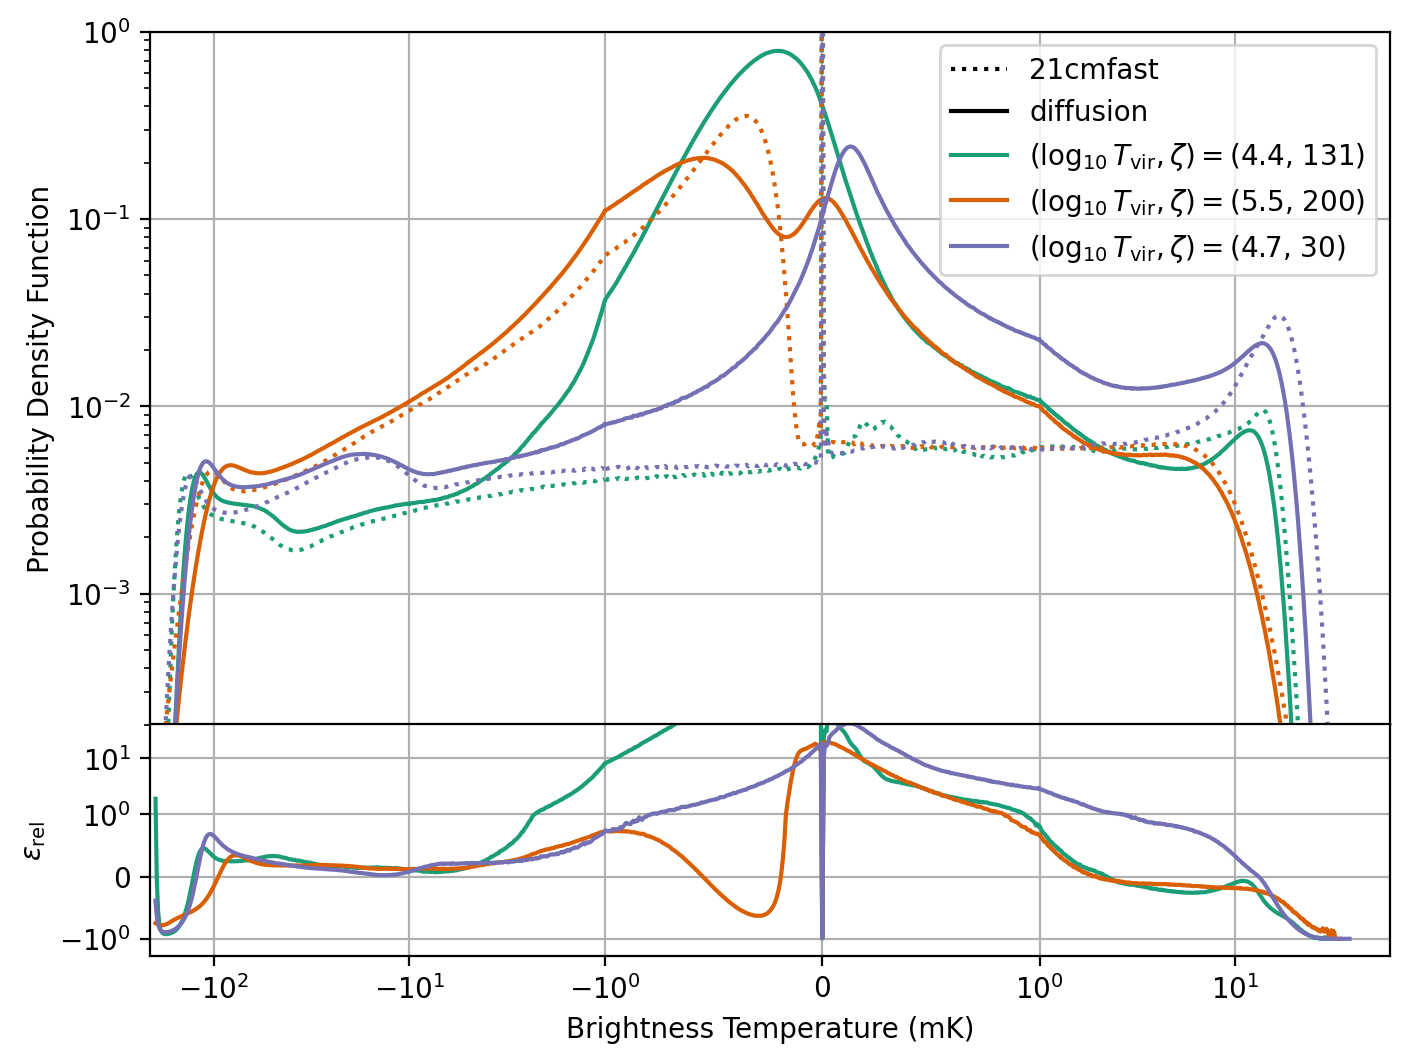

⚠️ plot_Tb_lightcone: samples.shape = (12, 1, 64, 64, 512)
Image saved to Tbs_47032656_0.png


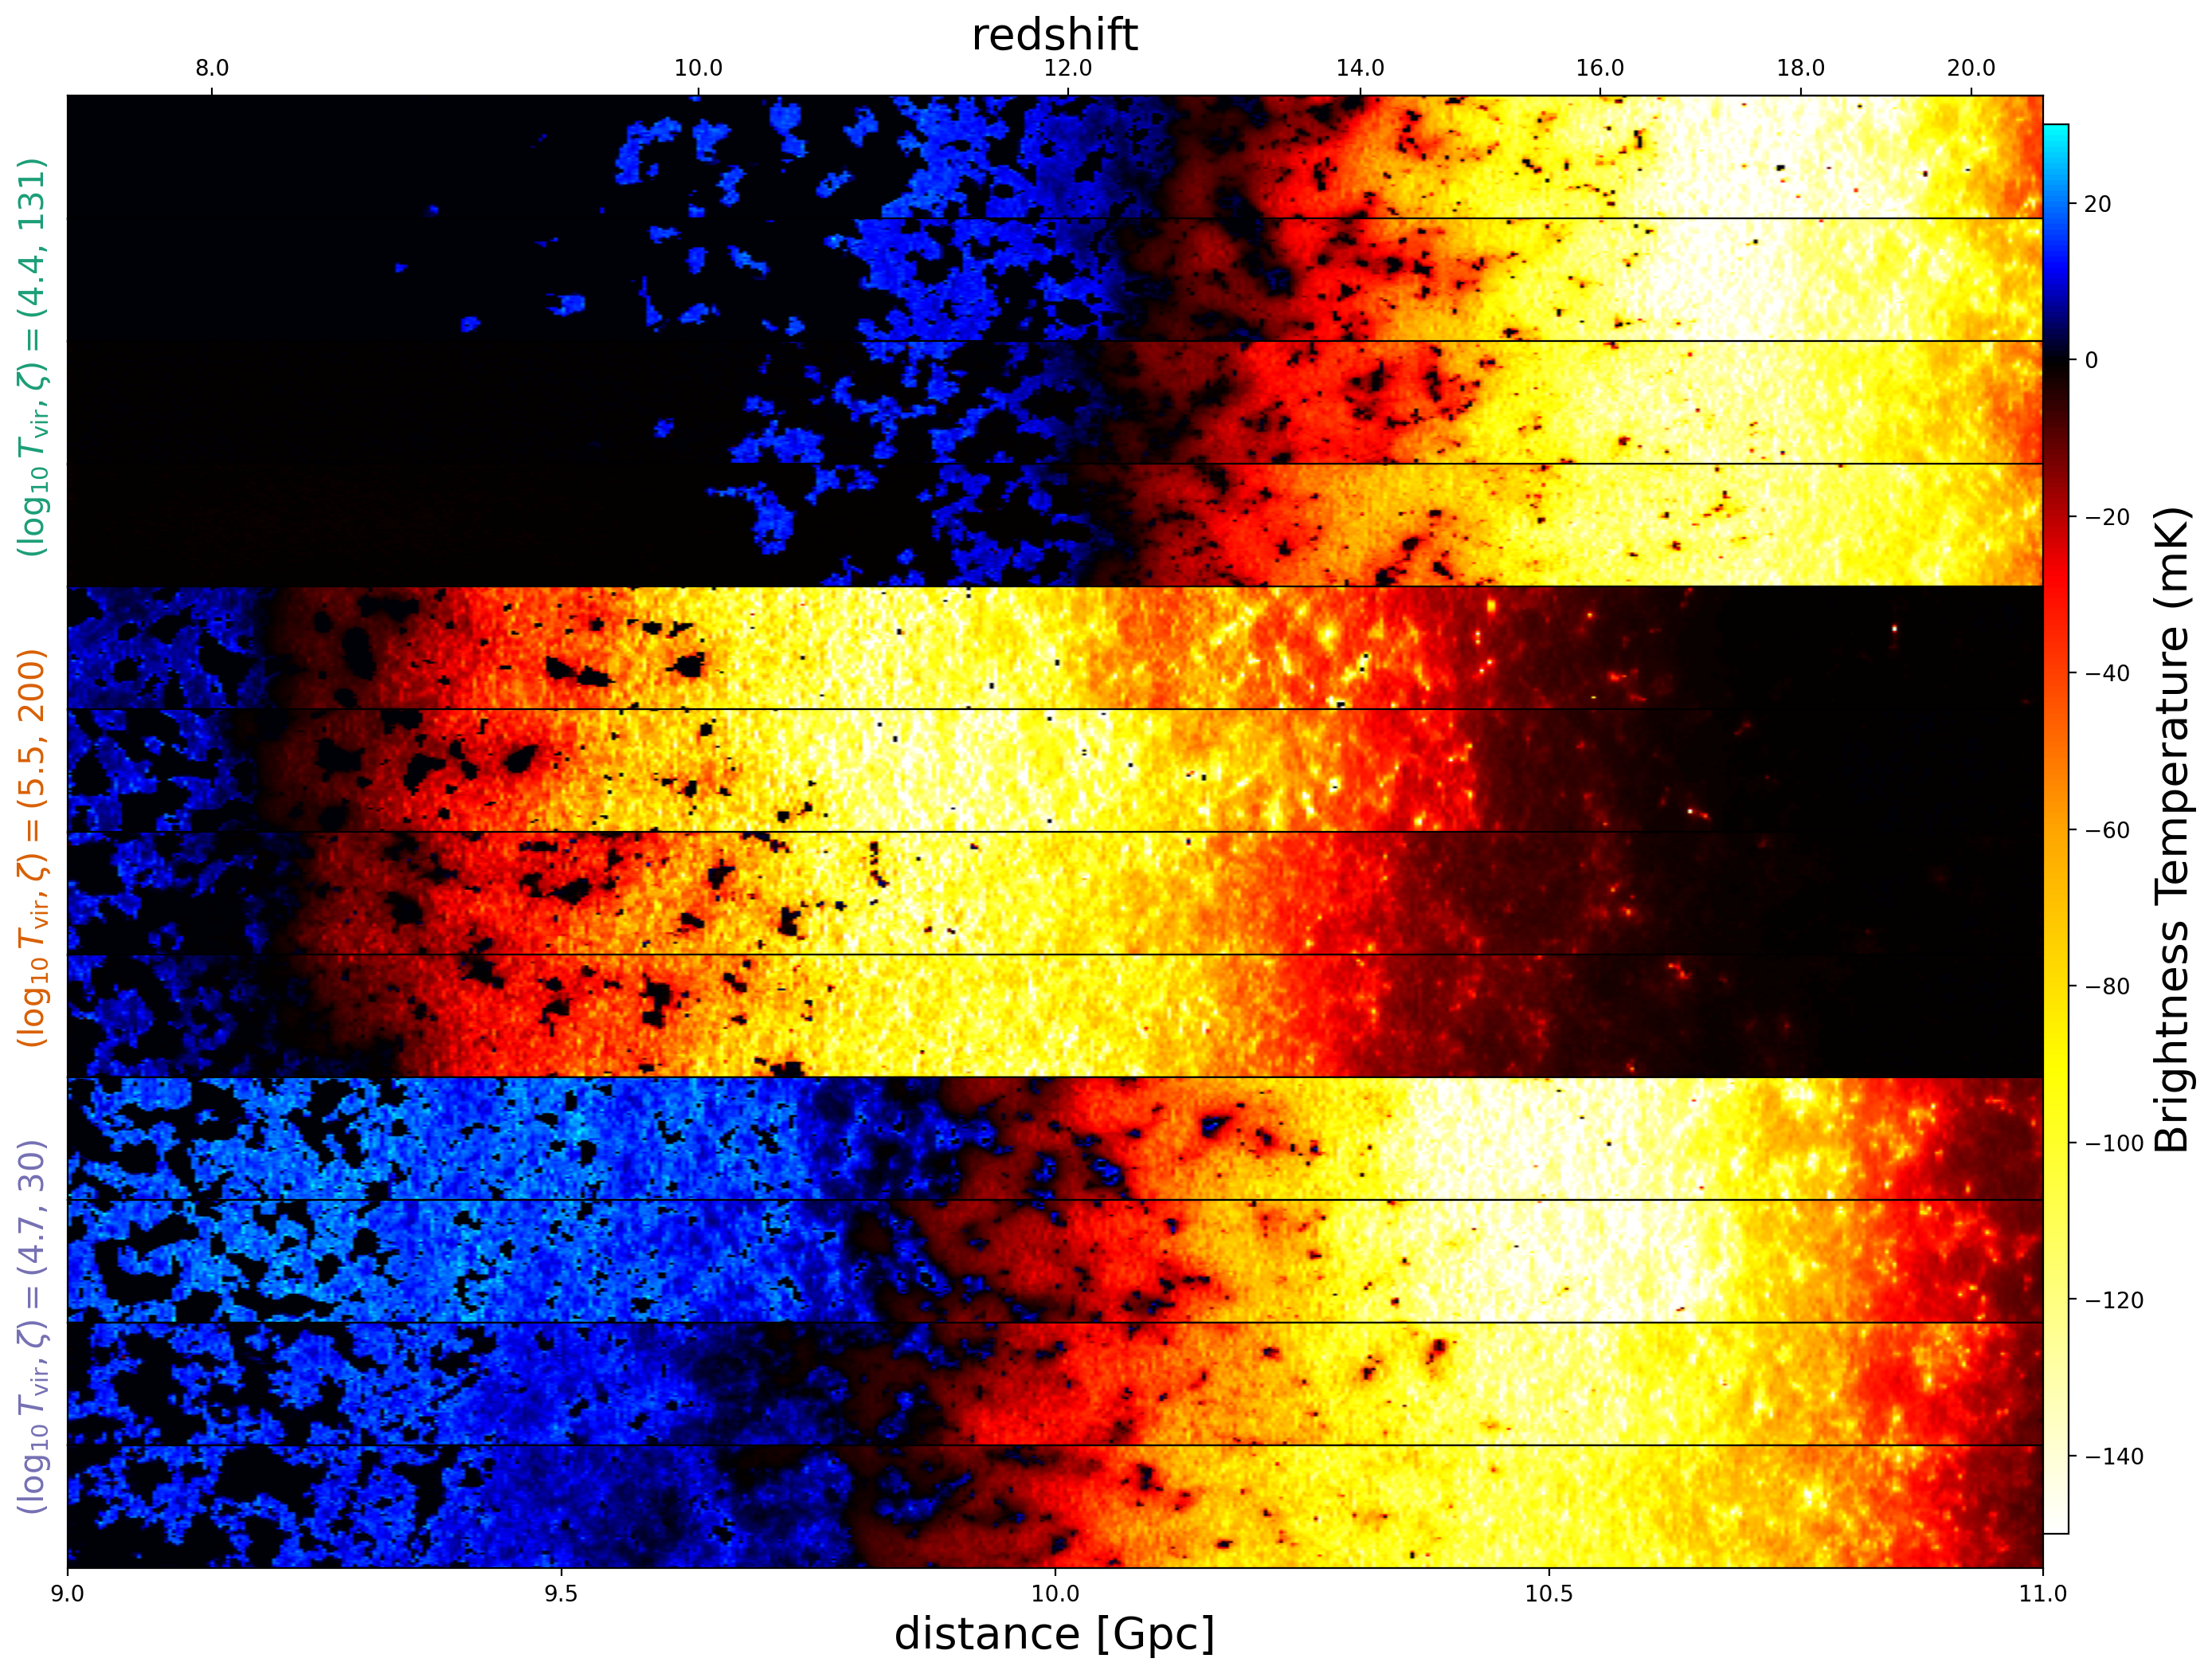

/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z0.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z0.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])


/tmp/ipykernel_1153394/1533992712.py:25: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1533992712.py:31: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1533992712.py:34: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z0.png
Image saved to Tbs_grid_47032656_0_z88.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z88.png


Processing z slices:  38%|███▊      | 12/32 [01:48<02:56,  8.81s/it]

Image saved to scattering_coefficients_47032656_0_z88.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z96.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z96.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z96.png


Processing z slices:  41%|████      | 13/32 [01:57<02:45,  8.73s/it]

Image saved to scattering_coefficients_47032656_0_z96.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z104.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z104.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z104.png


Processing z slices:  44%|████▍     | 14/32 [02:06<02:40,  8.94s/it]

Image saved to scattering_coefficients_47032656_0_z104.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z112.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z112.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z112.png


Processing z slices:  47%|████▋     | 15/32 [02:15<02:30,  8.83s/it]

Image saved to scattering_coefficients_47032656_0_z112.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z120.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z120.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z120.png


Processing z slices:  50%|█████     | 16/32 [02:24<02:21,  8.82s/it]

Image saved to scattering_coefficients_47032656_0_z120.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z128.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z128.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z128.png


Processing z slices:  53%|█████▎    | 17/32 [02:34<02:17,  9.15s/it]

Image saved to scattering_coefficients_47032656_0_z128.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z136.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z136.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z136.png


Processing z slices:  56%|█████▋    | 18/32 [02:42<02:06,  9.03s/it]

Image saved to scattering_coefficients_47032656_0_z136.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z144.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z144.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z144.png


Processing z slices:  59%|█████▉    | 19/32 [02:51<01:56,  9.00s/it]

Image saved to scattering_coefficients_47032656_0_z144.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z152.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z152.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z152.png


Processing z slices:  62%|██████▎   | 20/32 [03:00<01:47,  8.98s/it]

Image saved to scattering_coefficients_47032656_0_z152.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z160.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z160.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z160.png


Processing z slices:  66%|██████▌   | 21/32 [03:10<01:41,  9.25s/it]

Image saved to scattering_coefficients_47032656_0_z160.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z168.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z168.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z168.png


Processing z slices:  69%|██████▉   | 22/32 [03:19<01:30,  9.09s/it]

Image saved to scattering_coefficients_47032656_0_z168.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z176.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z176.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z176.png


Processing z slices:  72%|███████▏  | 23/32 [03:28<01:21,  9.00s/it]

Image saved to scattering_coefficients_47032656_0_z176.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z184.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z184.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z184.png


Processing z slices:  75%|███████▌  | 24/32 [03:36<01:11,  8.91s/it]

Image saved to scattering_coefficients_47032656_0_z184.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z192.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z192.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z192.png


Processing z slices:  78%|███████▊  | 25/32 [03:45<01:01,  8.75s/it]

Image saved to scattering_coefficients_47032656_0_z192.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z200.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z200.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z200.png


Processing z slices:  81%|████████▏ | 26/32 [03:55<00:54,  9.13s/it]

Image saved to scattering_coefficients_47032656_0_z200.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z208.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z208.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z208.png


Processing z slices:  84%|████████▍ | 27/32 [04:03<00:44,  8.94s/it]

Image saved to scattering_coefficients_47032656_0_z208.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z216.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z216.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z216.png


Processing z slices:  88%|████████▊ | 28/32 [04:12<00:35,  8.78s/it]

Image saved to scattering_coefficients_47032656_0_z216.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z224.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z224.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z224.png


Processing z slices:  91%|█████████ | 29/32 [04:20<00:26,  8.69s/it]

Image saved to scattering_coefficients_47032656_0_z224.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z232.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z232.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z232.png


Processing z slices:  94%|█████████▍| 30/32 [04:29<00:17,  8.64s/it]

Image saved to scattering_coefficients_47032656_0_z232.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z240.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z240.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z240.png


Processing z slices:  97%|█████████▋| 31/32 [04:39<00:09,  9.16s/it]

Image saved to scattering_coefficients_47032656_0_z240.png


/tmp/ipykernel_1153394/1701254129.py:27: RuntimeWarning: divide by zero encountered in divide
  eps_rel = ((y1-y0)/abs(y0))[abs(y0)>y_eps]
/tmp/ipykernel_1153394/1701254129.py:33: RuntimeWarning: divide by zero encountered in divide
  eps_std = ((y1-y0)/sigma0)[sigma0>y_eps]
/tmp/ipykernel_1153394/1701254129.py:37: RuntimeWarning: divide by zero encountered in divide
  eps_sigma = (sigma1/sigma0-1)[sigma0>y_eps]


Image saved to global_Tb_47032656_0_z248.png
⚠️ plot_Tb_grid: samples.shape = (3, 8, 64, 64, 512)
⚠️ distance.min()=8973.25414128504, distance.max()=11019.244404186697, redshift.min()=7.5100000156946995, redshift.max()=20.924346714121455
Image saved to Tbs_grid_47032656_0_z248.png
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
x2Pk, x.shape = torch.Size([320, 1, 64, 64, 512])
Image saved to power_spectrum_47032656_0_z248.png


Processing z slices: 100%|██████████| 32/32 [04:48<00:00,  9.01s/it]

Image saved to scattering_coefficients_47032656_0_z248.png


Generated 32 scaled panel frames in panels/


ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --ena

Created MP4: pt_inv_47032656.mp4


[mp4 @ 0x56254baae680] Starting second pass: moving the moov atom to the beginning of the file
[out#0/mp4 @ 0x56254baad540] video:9350kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.012272%
frame=   32 fps=6.7 q=-1.0 Lsize=    9351kB time=00:00:14.50 bitrate=5283.2kbits/s speed=3.02x    
[libx264 @ 0x56254baaef80] frame I:1     Avg QP:11.70  size:864405
[libx264 @ 0x56254baaef80] frame P:24    Avg QP:16.98  size:311678
[libx264 @ 0x56254baaef80] frame B:7     Avg QP:21.27  size:175603
[libx264 @ 0x56254baaef80] consecutive B-frames: 65.6% 12.5%  9.4% 12.5%
[libx264 @ 0x56254baaef80] mb I  I16..4: 52.0% 14.7% 33.3%
[libx264 @ 0x56254baaef80] mb P  I16..4:  2.8%  2.6%  5.8%  P16..4: 10.2%  9.8%  7.0%  0.0%  0.0%    skip:61.7%
[libx264 @ 0x56254baaef80] mb B  I16..4:  0.5%  0.2%  1.3%  B16..8: 13.0% 10.1%  4.9%  direct: 5.9%  skip:64.2%  L0:51.5% L1:39.3% BI: 9.3%
[libx264 @ 0x56254baaef80] 8x8 transform intra:20.4% inter:55.0%
[libx264 @ 0x56254baaef80] 

In [13]:
if __name__ == '__main__':
    sys.argv = ['notebook', '-j', '47032656', '-z', '2', '-t', 'pt_inv']
    # 'pt_inv': '44099514'; 'min_max': '35913062'; 'z_score': '36915598'
    parser = argparse.ArgumentParser()
    parser.add_argument("-j", "--jobID", type=int, required=True)
    parser.add_argument("-z", "--z_step", type=int, default=1)
    parser.add_argument("-t", "--transform", type=str, default='pt_inv', choices=['pt_inv', 'pt', 'min_max', 'z_score', 'arcsinh'])
    args = parser.parse_args()

    evaluate(
            # what2plot = ['stack_Tb', 'global_signal', 'power_spectrum', 'scatter_transform'],
            jobID = args.jobID,
            use_ema = 0,
            z_step = args.z_step,
            transform = args.transform if 'transform' in args else 'pt_inv',
            )

    plot_mp4(args.jobID, seconds=16, transform=args.transform)

---